# Train the chatbot

This is remotely based on the amalgamation of [this](https://github.com/saltypaul/Seq2Seq-Chatbot)
and [that](https://github.com/marekrei/sequence-labeler) repositories. The images are taken from
the first one.

In [1]:
import os
import time
import json
import pickle

import numpy as np

import pandas as pd
import tqdm

We'll definitely need to plot something

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Uninterruptible section

In [3]:
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

Fix the random seed

In [4]:
random_state = np.random.RandomState(0x0BADC0DE)

Import Theano and Lasagne

In [5]:
# %env THEANO_FLAGS='device=cuda0,force_device=True,mode=FAST_RUN,floatX=float32'

import theano
theano.config.exception_verbosity = 'high'

import theano.tensor as tt

import lasagne
from lasagne.utils import floatX

Using cuDNN version 5103 on context None
Mapped name None to device cuda: GeForce GTX 980 Ti (0000:06:00.0)


Fix Lasagne's random seed.

In [6]:
lasagne.random.set_rng(np.random.RandomState(0xDEADC0DE))

Load the line lookup table. It was generated from the [Cornell Movie--Dialogs Corpus](https://people.mpi-sws.org/~cristian/Cornell_Movie-Dialogs_Corpus.html)

In [7]:
with open("../processed_lines.json", "r", encoding="utf-8") as fin:
    db_lines = {k: "\x02" + v + "\x03" for k, v in json.load(fin).items()}

Load the diaogues into Q&A pairs

In [8]:
with open("../processed_dialogues.json", "r", encoding="utf-8") as fin:
    db_dialogues = json.load(fin)

qa_pairs = []
for lines in db_dialogues:
    qa_pairs.extend(zip(lines[:-1], lines[1:]))
del db_dialogues

# for easier indexing
qa_pairs = np.array(qa_pairs)

Build the vocabulary

In [9]:
from collections import Counter
token_counts = Counter(c for l in db_lines.values() for c in l[1:-1])

## It is very important that these service characters be added first
vocab = ["\x02", "\x03"]
vocab += [c for c, f in token_counts.items()]

token_to_index = {w: i for i, w in enumerate(vocab)}

A function to lines into character id vectors.

In [10]:
def as_matrix(lines, max_len=None):
    if isinstance(lines, str):
        lines = [lines]

    length = max(map(len, lines))
    length = min(length, max_len or length)

    matrix = np.full((len(lines), length), -1, dtype='int32')
    for i, line in enumerate(lines):
        row_ix = [token_to_index.get(c, -1)
                  for c in line[:length]]

        matrix[i, :len(row_ix)] = row_ix

    return matrix

A function to convert History-Reply pairs into character id matrices

In [11]:
def retrieve_sentences(pairs):
    enc, dec = [], []
    for q, a in pairs:
        enc.append(db_lines[q])
        dec.append(db_lines[a])
    return enc, dec

def get_matrices(pairs, max_len=None):
    enc, dec = retrieve_sentences(pairs)
    return as_matrix(enc, max_len), as_matrix(dec, max_len)

A function to sample a batch from History-Reply pairs

In [12]:
def generate_batch(batch_size=32, max_len=None):
    n_batches = (len(qa_pairs) + batch_size - 1) // batch_size
    indices_ = random_state.permutation(len(qa_pairs))
    
    for i in range(n_batches):
        yield get_matrices(qa_pairs[indices_[i::n_batches]], max_len)

Define a simple seq2seq network (preferably in Lasagne)

In [13]:
from lasagne.layers import InputLayer, EmbeddingLayer
from lasagne.layers import GRULayer, DenseLayer
from lasagne.layers import NonlinearityLayer

from broadcast import BroadcastLayer, UnbroadcastLayer
from lasagne.layers import SliceLayer

from lasagne.layers.base import Layer

The architecture hyper parameters

In [14]:
model_file = "pickles/experimental_mdl_epoch-05.pkl"
if os.path.exists(model_file):
    with open(model_file, "rb") as fin:
        ver, *rest = pickle.load(fin)
        assert ver == "2.5EXP"

    hyper, vocab, weights = rest

else:
    hyper = {
        "n_embed_char": 32,
        "n_hidden_decoder": 256,
        "n_hidden_encoder": 256,
        "n_layers_decoder": 4,
        "n_layers_encoder": 2,
    }

Set shortcuts

In [15]:
n_embed_char = hyper["n_embed_char"]          # 32
n_hidden_encoder = hyper["n_hidden_encoder"]  # 256
n_hidden_decoder = hyper["n_hidden_decoder"]  # 256
n_layers_encoder = hyper["n_layers_encoder"]  # 2
n_layers_decoder = hyper["n_layers_decoder"]  # 4

<img src="https://raw.githubusercontent.com/saltypaul/Seq2Seq-Chatbot/master/pics/Training%20Phase.jpg" />

### Embedding subgraph (pinkish)

A helper to create stacked RNN

In [16]:
from lasagne.layers.base import Layer

def gru_column(input, num_units, hidden, **kwargs):
    kwargs.pop("only_return_final", None)
    assert isinstance(hidden, (list, tuple))

    name = kwargs.pop("name", "default")
    column = [input]
    for i, l_hidden in enumerate(hidden):
        kwargs_ = kwargs.copy()
        if isinstance(l_hidden, Layer):
            kwargs_.pop("learn_init", None)
            kwargs_["hid_init"] = l_hidden

        layer = GRULayer(column[-1], num_units,
                         name=os.path.join(name, "gru_%02d" % i),
                         **kwargs_)
        column.append(layer)
    return column[1:]

Create readouts of the last hidden state

In [17]:
def gru_hidden_readout(column, indices):
    hidden = []
    for layer in column:
        name = os.path.join(layer.name, "slice")
        slice_ = SliceLayer(layer, indices, axis=1, name=name)
        hidden.append(slice_)
    return hidden

### Encoder

Tap into the common embedding layer

In [18]:
l_encoder_mask = InputLayer((None, None), name="encoder/mask")
l_encoder_embed = InputLayer((None, None, n_embed_char), name="encoder/input")

### Sentence representation

Construct layered GRU columns atop the embedding (we can also make parallel fwd / rev layers)

In [19]:
hidden = n_layers_encoder * [None]
enc_rnn_layers = gru_column(l_encoder_embed, n_hidden_encoder, hidden,
                            mask_input=l_encoder_mask, learn_init=True,
                            backwards=False, name="encoder")

enc_rnn_layers_sliced = gru_hidden_readout(enc_rnn_layers, -1)

### Decoder

Tap into the common embedding layer but with decoder's own input.

In [20]:
l_decoder_mask = InputLayer((None, None), name="decoder/mask")
l_decoder_embed = InputLayer((None, None, n_embed_char), name="decoder/input")

Project the hidden state of the encoder

In [21]:
from lasagne.layers import ConcatLayer
from lasagne.layers import BatchNormLayer

l_hidden_pool = ConcatLayer(enc_rnn_layers_sliced, axis=-1, name="encoder/cat")

l_fc_layer = DenseLayer(l_hidden_pool, n_layers_encoder * n_hidden_encoder,
                        nonlinearity=None, name="encoder/fc/core")

l_fc_bn = BatchNormLayer(l_fc_layer, name="encoder/fc/bn")
l_fc_relu = NonlinearityLayer(l_fc_bn, name="encoder/fc/tanh",
                              nonlinearity=lasagne.nonlinearities.tanh)

# l_bottleneck = DenseLayer(l_fc_relu, n_hidden_encoder,
#                           nonlinearity=None, name="encoder/bottleneck")
l_bottleneck = l_fc_relu

Construct projections

In [22]:
dec_hid_inputs, n_base = [None], 1
for i in range(n_layers_decoder - 2):
    name = "decoder/proj_%02d" % (n_base + i)
    l_project = DenseLayer(l_bottleneck, n_hidden_decoder,
                           nonlinearity=None, name=os.path.join(name, "core"))

    l_project_bn = BatchNormLayer(l_project, name=os.path.join(name, "bn"))
    l_project_relu = NonlinearityLayer(l_project_bn, name=os.path.join(name, "tanh"),
                                       nonlinearity=lasagne.nonlinearities.tanh)

    dec_hid_inputs.append(l_project_relu)
dec_hid_inputs.append(None)

Construct layers of GRU-s which recieve the final state of the encoder's network.

In [23]:
dec_rnn_layers = gru_column(l_decoder_embed, n_hidden_decoder, dec_hid_inputs,
                            mask_input=l_decoder_mask, learn_init=True,
                            backwards=False, name="decoder")

dec_rnn_layers_sliced = gru_hidden_readout(dec_rnn_layers, -1)

Read the output of the top layer of the RNN and re-embed into the character space

In [24]:
l_decoder_reembedder = DenseLayer(dec_rnn_layers[-1], num_units=len(vocab),
                                  nonlinearity=None, num_leading_axes=2,
                                  name="decoder/project")

Construct the softmax layer

In [25]:
l_bc = BroadcastLayer(l_decoder_reembedder, broadcasted_axes=(0, 1), name="decoder/bc")
l_softmax = NonlinearityLayer(l_bc, nonlinearity=lasagne.nonlinearities.softmax, name="decoder/softmax")
l_decoder_output = UnbroadcastLayer(l_softmax, l_bc, name="decoder/ub")

### Embedding layer 

The common embedding layer

In [26]:
l_input_char = InputLayer((None, None), name="char/input")
l_embed_char = EmbeddingLayer(l_input_char, len(vocab), n_embed_char, name="char/embed")

### Resume training

In [27]:
lasagne.layers.set_all_param_values(l_embed_char,
                                    weights["l_embed_char"])
lasagne.layers.set_all_param_values(l_decoder_reembedder,
                                    weights["l_decoder_reembedder"])

### Loss

Collect the encoder input

In [28]:
v_encoder_input = tt.imatrix(name="encoder/input")
v_encoder_embed = l_embed_char.get_output_for(v_encoder_input)

inputs = {l_encoder_embed: v_encoder_embed,
          l_encoder_mask: tt.ge(v_encoder_input, 0)}

And the decoder's inputs

In [29]:
v_decoder_input = tt.imatrix(name="decoder/input")
v_decoder_embed = lasagne.layers.get_output(l_embed_char, v_decoder_input)

inputs.update({l_decoder_embed: v_decoder_embed,
               l_decoder_mask: tt.ge(v_decoder_input, 0)})

Get the output of the decoder

In [30]:
v_decoder_output, v_decoder_mask = lasagne.layers.get_output(
    [l_decoder_output, l_decoder_mask], inputs, deterministic=False)

Slice the output to match the forward character-level language model

In [31]:
v_predicted = v_decoder_output[:, :-1].reshape(
    (-1, v_decoder_output.shape[-1]))

v_targets = v_decoder_input[:, 1:].reshape((-1,))

v_mask = v_decoder_mask[:, 1:].reshape((-1,))

Construct the cross-entropy loss

In [32]:
loss_ij = lasagne.objectives.categorical_crossentropy(v_predicted, v_targets)
loss = (loss_ij * v_mask).sum()
loss /= v_mask.sum()

It can be benefitial to project the character embeddings onto the unit sphere.
However we are going to project the embeddings into the unit $l^2$ ball instead.

In [33]:
W_emb = l_embed_char.get_params()[0]

op_project_embedding = theano.function([], updates={
    W_emb: W_emb / tt.maximum(W_emb.norm(2, axis=-1, keepdims=True), 1.0)
})

On the other hand we can always add $l^2$ regularization term.

In [34]:
if False:
    C_embed = 1e-1
    loss += C_embed * W_emb.norm(2, axis=-1).mean()

Collect all trainable parameters 

In [35]:
trainable = []
trainable.extend(lasagne.layers.get_all_params(l_embed_char, trainable=True))
trainable.extend(lasagne.layers.get_all_params(l_decoder_output, trainable=True))

Get the updates

In [36]:
learning_rate = theano.shared(floatX(1e-3), name="eta")

# updates = lasagne.updates.sgd(loss, trainable, learning_rate)
updates = lasagne.updates.adam(loss, trainable, learning_rate)

Create the ops

In [37]:
op_train = theano.function([v_decoder_input, v_encoder_input], loss,
                           updates=updates, givens={},
                           mode=theano.Mode(optimizer="fast_run"))

In [38]:
op_test_loss = theano.function([v_decoder_input, v_encoder_input], loss,
                               mode=theano.Mode(optimizer="fast_run"))

In [39]:
op_predict = theano.function([v_decoder_input, v_encoder_input],
                             v_decoder_output,
                             mode=theano.Mode(optimizer="fast_run"))

In [40]:
# inputs_ = {l_encoder_embed: v_encoder_embed,
#            l_encoder_mask: tt.ge(v_encoder_input, 0),
#            l_decoder_embed: v_decoder_embed,
#            l_decoder_mask: tt.ge(v_decoder_input, 0)}

v_decoder_logits = lasagne.layers.get_output(l_decoder_reembedder, inputs, deterministic=True)

op_predict_logits = theano.function([v_decoder_input, v_encoder_input],
                                     v_decoder_logits, mode=theano.Mode(optimizer="fast_run"))

In [41]:
trainable

[char/embed.W,
 decoder/gru_00.W_in_to_updategate,
 decoder/gru_00.W_hid_to_updategate,
 decoder/gru_00.b_updategate,
 decoder/gru_00.W_in_to_resetgate,
 decoder/gru_00.W_hid_to_resetgate,
 decoder/gru_00.b_resetgate,
 decoder/gru_00.W_in_to_hidden_update,
 decoder/gru_00.W_hid_to_hidden_update,
 decoder/gru_00.b_hidden_update,
 decoder/gru_00.hid_init,
 encoder/gru_00.W_in_to_updategate,
 encoder/gru_00.W_hid_to_updategate,
 encoder/gru_00.b_updategate,
 encoder/gru_00.W_in_to_resetgate,
 encoder/gru_00.W_hid_to_resetgate,
 encoder/gru_00.b_resetgate,
 encoder/gru_00.W_in_to_hidden_update,
 encoder/gru_00.W_hid_to_hidden_update,
 encoder/gru_00.b_hidden_update,
 encoder/gru_00.hid_init,
 encoder/gru_01.W_in_to_updategate,
 encoder/gru_01.W_hid_to_updategate,
 encoder/gru_01.b_updategate,
 encoder/gru_01.W_in_to_resetgate,
 encoder/gru_01.W_hid_to_resetgate,
 encoder/gru_01.b_resetgate,
 encoder/gru_01.W_in_to_hidden_update,
 encoder/gru_01.W_hid_to_hidden_update,
 encoder/gru_01.b_hid

### The generator

<img src="https://raw.githubusercontent.com/saltypaul/Seq2Seq-Chatbot/master/pics/Eval.jpg" />

A handy slicer (copied and modified)

In [42]:
def slice_(x, i, n):
    s = x[..., slice(i, i + n)]
    return s if n > 1 else tt.addbroadcast(s, -1)

Define one step of the scan function

In [43]:
# Generator's one step update function
def generator_step_sm(x_tm1, h_tm1, m_tm1, tau, eps):
    """One step of the generative decoder version."""
    # x_tm1 is `BxT` one-hot, h_tm1 is `batch x ...`
    # m_tm1 is `batch`, tau, eps are scalars

    # collect the inputs
    inputs = {l_decoder_embed: x_tm1.dimshuffle(0, "x", 1),
              l_decoder_mask: m_tm1.dimshuffle(0, "x")}

    # Connect the prev variables to the the hidden and stack state feeds
    j = 0
    for layer in dec_rnn_layers:
        inputs[layer.hid_init] = slice_(h_tm1, j, layer.num_units)
        j += layer.num_units

    # Get the outputs
    outputs = [l_decoder_reembedder] + dec_rnn_layers_sliced

    # propagate through the decoder column
    logit_t, *h_t_list = lasagne.layers.get_output(outputs, inputs,
                                                   deterministic=True)

    # Pack the hidden states
    h_t = tt.concatenate(h_t_list, axis=-1)
    
    # Generate the next symbol: logit_t is `Bx1xV`
    logit_t = logit_t[:, 0]
    prob_t = tt.nnet.softmax(logit_t)

    # Gumbel-softmax sampling: Gumbel (e^{-e^{-x}}) distributed random noise
    gumbel = -tt.log(-tt.log(theano_random_state.uniform(size=logit_t.shape) + eps) + eps)
#     logit_t = theano.ifelse.ifelse(tt.gt(tau, 0), gumbel + logit_t, logit_t)
#     inv_temp = theano.ifelse.ifelse(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))
    logit_t = tt.switch(tt.gt(tau, 0), gumbel + logit_t, logit_t)
    inv_temp = tt.switch(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))

    # Get the softmax: x_t is `BxV`
    x_t = tt.nnet.softmax(logit_t * inv_temp)

    # Get the best symbol
    c_t = tt.cast(tt.argmax(x_t, axis=-1), "int8")

    # Get the estimated probability of the picked symbol.
    p_t = prob_t[tt.arange(c_t.shape[0]), c_t]

    # Compute the mask and inhibit the propagation on a stop symbol.
    # Recurrent layers return the previous state if m_tm1 is Fasle
    m_t = m_tm1 & tt.gt(c_t, vocab.index("\x03"))
    c_t = tt.switch(m_t, c_t, vocab.index("\x03"))

    # There is no need to freeze the states as they will be frozen by
    # the RNN passthrough according to the mask `m_t`.

    # Embed the current character.
    x_t = tt.dot(x_t, l_embed_char.W)

    return x_t, h_t, m_t, p_t, c_t

Create scalar inputs to the scan loop. Also initialize the random stream.

In [44]:
theano_random_state = tt.shared_randomstreams.RandomStreams(seed=42)

eps = tt.fscalar("generator/epsilon")
n_steps = tt.iscalar("generator/n_steps")
tau = tt.fscalar("generator/gumbel/tau")

Let's compile an autofeeding generator with softmax.

In [45]:
v_gen_input = tt.imatrix(name="generator/Q_input")

v_gen_embed = lasagne.layers.get_output(l_embed_char, v_gen_input)

Helper functions to freeze the GRULayer's hidden input's initialization,
if one is a parameter.

In [46]:
def GRULayer_freeze(layer, input):
    assert isinstance(layer, GRULayer)
    if isinstance(layer.hid_init, Layer):
        return layer

    assert not (layer.hid_init_incoming_index > 0)
    assert isinstance(layer.hid_init, theano.compile.SharedVariable)

    # Broadcast the fixed /learnt hidden init over the batch dimension
    hid_init = tt.dot(tt.ones((input.shape[0], 1)), layer.hid_init)

    # Create a fake Input Layer, which receives it as input
    layer._old_hid_init = layer.hid_init
    layer.hid_init = InputLayer((None, None), input_var=hid_init,
                                name=os.path.join(layer.name,
                                                  "hid_init_fix"))
    
    # Cache former values
    layer._old_input_layers = layer.input_layers
    layer._old_input_shapes = layer.input_shapes
    layer._old_hid_init_incoming_index = layer.hid_init_incoming_index
    
    # Emulate hidden layer input (is in GRULayer/MergeLayer.__init__())
    layer.input_layers.append(layer.hid_init)
    layer.input_shapes.append(layer.hid_init.output_shape)
    layer.hid_init_incoming_index = len(layer.input_layers) - 1

    layer._layer_frozen = True
    return layer

Freeze the hidden inputs of the decoder layers, which do not tap into the encoder.

In [47]:
for layer in dec_rnn_layers:
    GRULayer_freeze(layer, v_gen_input)

Readout the last state from the encoder.

In [48]:
inputs = {l_encoder_embed: v_gen_embed,
          l_encoder_mask: tt.ge(v_gen_input, 0)}
outputs = [l.hid_init for l in dec_rnn_layers]

dec_hid_inits = lasagne.layers.get_output(outputs, inputs,
                                          deterministic=True)

Prepare the initial values.

In [49]:
h_0 = tt.concatenate(dec_hid_inits, axis=-1)

x_0 = tt.fill(tt.zeros((v_gen_input.shape[0],), dtype="int32"),
              vocab.index("\x02"))
x_0 = lasagne.layers.get_output(l_embed_char, x_0)

m_0 = tt.ones((v_gen_input.shape[0],), 'bool')

Add a scan op and compile

In [50]:
result, updates = theano.scan(generator_step_sm, sequences=None, n_steps=n_steps,
                              outputs_info=[x_0, h_0, m_0, None, None],
                              strict=False, return_list=True,
                              non_sequences=[tau, eps], go_backwards=False,
                              name="generator/scan")
x_t, h_t, m_t, p_t, c_t = [r.swapaxes(0, 1) for r in result]

compile_mode = theano.Mode(optimizer="fast_run", linker="cvm")
op_generate = theano.function([v_gen_input, n_steps, tau],
                              [c_t, h_t, m_t, p_t],
                              updates=updates, givens={eps: floatX(1e-20)},
                              mode=compile_mode)

This function undoes the frrezing by the previous one

In [51]:
def GRULayer_unfreeze(layer):
    assert isinstance(layer, GRULayer)
    freeze_attr = ["_layer_frozen",
                   "_old_input_layers", "_old_input_shapes",
                   "_old_hid_init_incoming_index", "_old_hid_init"]
    if not all(hasattr(layer, a) for a  in freeze_attr):
        return layer

    assert layer._layer_frozen
    assert isinstance(layer.hid_init, Layer)
    assert layer.hid_init.name.endswith("/hid_init_fix")

    # Thawe the frozen hidden input
    layer.hid_init = layer._old_hid_init
    layer.input_layers = layer._old_input_layers
    layer.input_shapes = layer._old_input_shapes
    layer.hid_init_incoming_index = layer._old_hid_init_incoming_index
    
    for attr in freeze_attr:
        delattr(layer, attr)

    return layer

Unfreeze the decoder's layer, so that those which do not tap in to the encoder,
may continue to use / learn their own `hid_init` state.

In [52]:
for layer in dec_rnn_layers:
    GRULayer_unfreeze(layer)

A generator procedure, which automatically select the best replies (lowest perplexity).

In [53]:
def generate(questions, n_steps, n_samples=10, tau=0, seed=None):
    results = []
    for question in questions:
        # Replicate the query
        question = np.repeat(question[np.newaxis], n_samples, axis=0)
        if seed is not None:
            theano_random_state.seed(seed)
        x_t, h_t, m_t, p_t = op_generate(question, n_steps, tau)

        # may produce NaN, but they are shifted in the back by arsort
        perplexity, n_chars = (- np.log2(p_t) * m_t).sum(axis=-1), m_t.sum(axis=-1)
        perplexity /= n_chars

        result = []
        for i in perplexity.argsort():
            reply = "".join(map(vocab.__getitem__, x_t[i, :n_chars[i]]))
            result.append((reply, perplexity[i]))
        results.append(result)
    return results

<br/>

### Train the Bot

In [54]:
def sample_qa():
    sample = qa_pairs[random_state.choice(len(qa_pairs), 3)]
    enc, dec = retrieve_sentences(sample)

    replies = generate(as_matrix(enc), 140, tau=2**-5, n_samples=20)
    for e, d, r in zip(enc, dec, replies):
        tqdm.tqdm.write("|%-40.40s | %-30.30s | %-30.30s|" % (e[1:-1], d[1:-1], r[0][0]))

Set the batch size and the number of epochs.

In [70]:
batch_size, n_epochs = 160, 5
epoch, loss_val_hist = 0, []

model_path = os.path.join("pickles", time.strftime("%Y%m%d-%H%M%S"))
if not os.path.exists(model_path):
    os.makedirs(model_path)

filename_fmt_ = os.path.join(model_path, "experimental_mdl_epoch-%02d%s.pkl")

Now let's train the shit!

In [ ]:
progress_fmt_, interrupted = "%(loss).3f", False
n_batches = (len(qa_pairs) + batch_size - 1) // batch_size
while epoch < n_epochs:
    try:
        with tqdm.tqdm(total=n_batches) as progress_:
            for i, (be, bd) in enumerate(generate_batch(batch_size, max_len=512)):
                if (i % 100) == 0:
                    sample_qa()

                with DelayedKeyboardInterrupt():
                    loss_val_hist.append(op_train(bd, be))
                    # op_project_embedding()

                progress_.postfix = progress_fmt_ % {
                    "loss": np.mean(loss_val_hist[-100:]),
                }
                progress_.update(1)
            # end for

        # end with
        epoch += 1
    except KeyboardInterrupt:
        interrupted = True

    finally:
        # retrieve the parameters
        weights = {
            "l_embed_char": lasagne.layers.get_all_param_values(l_embed_char),
            "l_decoder_reembedder": lasagne.layers.get_all_param_values(l_decoder_reembedder)
        }
        filename = filename_fmt_ % (epoch, "_interrupted" if interrupted else "")
        with open(filename, "wb") as fin:
            pickle.dump(("2.5EXP", hyper, vocab, weights), fin)

        if interrupted:
            break

  0%|          | 0/1386 [00:00<?, ?it/s]

|All right. Now the second one.           | First my girls. I get my girls | D5G4lI'TYOa?VUKa2 vsyAXxCXwik8|
|Oh. No. Strictly dryland.                | Too bad. You could use some su | mf5k3,wv.joghru6c9PXfvm20v5fv7|
|Who was that man?                        | It was nobody. Ah... he's a po | -R6P3 bX"JdW                  |


  7%|▋         | 100/1386 [02:12<26:52,  1.25s/it, 3.185]

|You ever see it before...like mebbe on a | Yes!..Yes, I remember!..Have t | Whh rtyl                      |
|Would you be prepared to handle this for | Are you proposing to transfer  | Ior' hhagoh                   |
|Aaah, it's the same as always...poor mop | I've been trying to get throug | Wol aee e m                   |


 14%|█▍        | 200/1386 [04:28<27:10,  1.38s/it, 2.592]

|No, no! I haven't heard any of this. I n | All my things? All the eightee | I laslate                     |
|What, and leave you here all by your lon | Uh...                          | Yhat's in dhene tocget, I lebe|
|Creasy. Just call me Creasy.             | Creasy...                      | Wowe you asd. Ind foren?      |


 22%|██▏       | 300/1386 [06:39<26:08,  1.44s/it, 2.063]

|Looks at her skeptically doesn't say a w | I did it.                      | Whell you now?                |
|The normal amount of build up in your ar | Can it kill me?                | What do?                      |
|Before Meeks disappeared he was popping  | Bullshit. Where would a two-bi | That's that tous?             |


 29%|██▉       | 400/1386 [08:48<22:54,  1.39s/it, 1.835]

|Oh my God. Aw, God.                      | The shutdown must have turned  | Yes.                          |
|Sera...                                  | Let's face it, Ben, we're havi | Yeah, what?                   |
|A hundred and fifty-six. Some'll charge  | A real bargain.                | That's the word wints.        |


 36%|███▌      | 500/1386 [11:01<19:09,  1.30s/it, 1.705]

|You, me and Harry?                       | You, me and Harry. He's asleep | You can call.                 |
|You're getting cold feet about this.     | I was just thinking what Ma wo | Oh... you have no mool!       |
|You've been off in daisyland, honey. Eve | But a priest...?               | He don't...                   |


 43%|████▎     | 600/1386 [13:12<17:08,  1.31s/it, 1.623]

|General Jim Beam, then.                  | Nope.                          | Yeah.                         |
|I mailed it to you on Wednesday.         | Well, today's Saturday and it' | I don't. If then there me.    |
|No.                                      | What is she, at work?          | Yeah?                         |


 51%|█████     | 700/1386 [15:25<16:22,  1.43s/it, 1.571]

|Yes.                                     | What is it?                    | Do you tell me witer.         |
|Look, you wanna be elite? You gotta do a | Oh yeah, you want a seriously  | What? What are you hard to go?|
|Hell...                                  | I was bored. I'd done everythi | What?                         |


 58%|█████▊    | 800/1386 [17:37<11:53,  1.22s/it, 1.531]

|Am I on that case, sir...?               | No.                            | You're know about him?        |
|It means who's side are you on?          | You didn't ask me to meet you  | Yeah. You hate guys this famil|
|"You don't care about anything except yo | love them so much that they ou | What's happen? Or that right? |


 65%|██████▍   | 900/1386 [19:49<11:33,  1.43s/it, 1.500]

|Is it real?                              | Or a fake?                     | I don't know is shit.         |
|Poor color composition, lousy use of spa | What does?                     | Thanks.                       |
|What band?                               | The band that found me and ask | You've started to you thank he|


 72%|███████▏  | 1000/1386 [22:00<08:24,  1.31s/it, 1.475]

|How's the job coming, Bob?               | Frankly, sir, it stinks. I hav | Oh, you couldn't.             |
|Beth -                                   | You did, didn't you?           | What do that?                 |
|How was your trip?                       | Nice... Very interesting... Gr | I'm sorry. For!               |


 79%|███████▉  | 1100/1386 [24:09<06:28,  1.36s/it, 1.453]

|Where were you going when you got in tha | I don't remember. Not so very  | I don't mean.                 |
|Right?! Mama, was it right for you to si | Did you run into Johnnie in Ne | We've been some fault somewher|
|Sir, I... come to beg you to confess all | Will he show mercy to my count | Okay.                         |


 87%|████████▋ | 1200/1386 [26:19<03:53,  1.26s/it, 1.438]

|Then why does he stay? My scouts say he  | He waits. For you. He says he  | Even have their time?         |
|If you don't - can you still afford to g | ... I don't know. Probably not | It's all...                   |
|But it did. I was there. This old man sa | Did you say, "I do"?           | Maybe over to you, we did it..|


 94%|█████████▍| 1300/1386 [28:31<01:45,  1.23s/it, 1.419]

|Okay?                                    | Unbelievably handsome. You loo | Nothing, good on. It wasn't on|
|Hey man, why don't you fucking listen oc | And please don't call her my m | What is it like me?           |
|Well, he passed on. He was killed in a m | He was? Gee, that's too bad. I | I don't know. That's out!     |


  0%|          | 0/1386 [00:00<?, ?it/s]

|Anyway, Major, why should he leave his c | But what... before that turns  | Yeah.                         |
|Did you find your father?                | Didn't see 'im, Mama. The othe | I can't stand him'ore.        |
|Really?                                  | Really.                        | What's the him?               |


  7%|▋         | 100/1386 [02:13<30:14,  1.41s/it, 1.399]

|How did she die? I wanna know.           | You don't wanna know.          | What?                         |
|The look on their faces when one walks i | I wouldn't know.               | You didn't. What is that hard?|
|Maybe he'll get tubed.                   | What?                          | So your everyone's going to ha|


 14%|█▍        | 200/1386 [04:27<26:02,  1.32s/it, 1.383]

|Not the focus.                           | You know what I mean.          | I mean, but I mean.           |
|What? Are you ashamed that we did it?    | No...                          | Like you to have a few man.   |
|What?                                    | The rings?                     | What?                         |


 22%|██▏       | 300/1386 [06:35<24:30,  1.35s/it, 1.373]

|Mom, tell him I'm not going. You already | You have everything?           | Yes.                          |
|Not because of Ned.                      | Of course not- -but isn't it a | I mean I'd have your alson my |
|C'mon, Forsythe. Are there any more on t | No. Dotty's the last.          | No, we don't...               |


 29%|██▉       | 400/1386 [08:51<18:48,  1.14s/it, 1.365]

|Frightened? You are talking to a man who | Ohhh!                          | I didn't hear your finger.    |
|Actually, I'm free Sunday.               | Now.                           | So what do you really also?   |
|Thanks. I suppose all this comes under t | We've had plenty of it the las | What?                         |


 36%|███▌      | 500/1386 [11:06<20:25,  1.38s/it, 1.363]

|What are all them books?                 | Different ones. One's the Bibl | What?                         |
|Daddy. Daddy, please...                  | Jim... for godsake!            | What?                         |
|No, I mean - about my client.            | Oh - we'll have to do somethin | Thank you...                  |


 43%|████▎     | 600/1386 [13:19<17:05,  1.30s/it, 1.352]

|I work in a shitty video store. I want t | Are you open?                  | What happeneed?               |
|You're OK by me.                         | Dr Scott I'm sorry about your  | Yes, sir.                     |
|I knew what he wanted, and I didn't want | Fuckin' walking around with a  | Where are you going?          |


 51%|█████     | 700/1386 [15:30<14:28,  1.27s/it, 1.352]

|What? What do you mean you don't belong  | Mrph mprhm mm rmph!            | What are you that day?        |
|You mean I can't even get outa here?     | Not tonight you can't. Want to | Yes.                          |
|Are you alright?                         | Just fine. I'll do the driving | Everyone seeing I don't unders|


 58%|█████▊    | 800/1386 [17:40<13:33,  1.39s/it, 1.343]

|Yeah. I got out.                         | What about you?                | What's your crimine?          |
|How do you work it with the key?         | Well, usually I slip it to the | I don't know. And a funny inte|
|You mean -                               | You found the body. She was on | Yeah, you're deiding other roo|


 65%|██████▍   | 900/1386 [19:55<10:49,  1.34s/it, 1.339]

|It's just a feeling. Don't you sense it, | What? What am I supposed to se | I promise.                    |
|Chauncey! Chauncey!                      | Hello, Eve.                    | All right. But afterendered.  |
|No. It happened when Graham went to see  | What's the bottom line?        | Why are you talking about?    |


 72%|███████▏  | 1000/1386 [21:50<07:20,  1.14s/it, 1.286]

|Maybe it went out. Should someone check  | Yeah, you do that, Lenny.      | What're you doing?            |
|Listen to what?                          | I need your help and I thin yo | I don't know.                 |
|...shivering...                          | ...And you're just looking at  | We're doing here.             |


 79%|███████▉  | 1100/1386 [24:03<06:52,  1.44s/it, 1.286]

|Please...                                | Don't... don't do this... plea | I'm tired to able to do it.   |
|You'll have no need for that, Highlander | Since we hardly know each othe | Sometimes I looked like you...|
|You can stay here if you like.           | We have to get to Sonora. Ther | Thank you.                    |


 87%|████████▋ | 1200/1386 [26:12<03:33,  1.15s/it, 1.282]

|Big. Frederick, show him the oils.       | They're in the basement.       | What are you talkin' arrection|
|John. John...                            | Will you please wait a second. | I think you think you have any|
|Yeah, it's good to get together.         | Do you mind if I raise a littl | But you had no matter.        |


 94%|█████████▍| 1300/1386 [28:26<02:08,  1.49s/it, 1.281]

|Has it changed since the last time you w | The trees are taller.          | Yeah.                         |
|What is ridiculous? Wolfi has many admir | But you can't take her without | Would you do something?       |
|What time do you get off work, my child? | I'm sorry, sir, I'm engaged to | I could be crazy.             |


  0%|          | 0/1386 [00:00<?, ?it/s]

|Such a nice ass.                         | And a lonely ass.              | What do you want to go home?  |
|Hunh-uh. Check the bread. He spreads it  | He probably sells insurance. O | How are you smooth?           |
|Sally Doneghy, now who is that?          | One lousy letter eighteen mont | Nothing.                      |


  7%|▋         | 100/1386 [02:10<30:11,  1.41s/it, 1.269]

|A little place with cabins. The somethin | And how long are you here for? | I don't think about it?       |
|This is ogre's magic.                    | Blackheart?                    | You saw -0... Wait a minute an|
|What do you want from me?                | Strength. Westerburg doesn't n | They're with a great party.   |


 14%|█▍        | 200/1386 [04:24<26:23,  1.34s/it, 1.268]

|He's free. His time's up. That's the rul | Signs?                         | Did you contract him with the |
|But all men like me, Lois. I'm very rich | ... And very naive!            | I didn't need to see hunched y|
|It's very difficult to put into a nutshe | Romance!                       | Thank you out.                |


 22%|██▏       | 300/1386 [06:31<24:15,  1.34s/it, 1.271]

|C'mon, c'mon, tell the truth...c'mon.    | They'll kill me.               | What mak?                     |
|Do I?                                    | You took it! All of it! And wh | What do you want to le exactly|
|Right.                                   | Do you have your masters?      | What did you lear everything? |


 29%|██▉       | 400/1386 [08:41<23:55,  1.46s/it, 1.269]

|Piss off, Dave!                          | Tough guy, huh? Are you going  | What if I here you want to go?|
|Your Ranger's on the garbage pile, Happy | Shut up! You've got the man pi | I don't know.                 |
|What's it about?                         | A priest who dies.             | Oh no! I won't have to save yo|


 36%|███▌      | 500/1386 [10:53<17:31,  1.19s/it, 1.264]

|So am I. Just trying to get by.          | No, you're just trying to get  | Where are you?                |
|I think maybe you'd better deliver him.  | Oh. Oh, well, all right.       | I'm sorry.                    |
|I have submitted my resignation to Bisho | But - why?                     | Anything else?                |


 43%|████▎     | 600/1386 [13:08<19:04,  1.46s/it, 1.264]

|I don't play for no team.                | Come on, jerky, you can tell m | You let me care other victory,|
|That's good. Cools you right off. I saw  | I'm sorry. I didn't mean to.   | What have you only have someth|
|Don't cry.                               | I can't help it. You don't kno | That's because I'm good... I'l|


 51%|█████     | 700/1386 [15:20<15:17,  1.34s/it, 1.261]

|What?                                    | I'm just a bit of a wreck. "I  | You're the one what you didn't|
|Really?                                  | And you know what else?        | Yes.                          |
|Yeah.                                    | It's Cloudy. Open the door.    | Believe me, how do you know so|


 58%|█████▊    | 800/1386 [17:30<11:26,  1.17s/it, 1.267]

|Forgive me, Father, for I have sinned. T | Prepare to receive the Act of  | I said I was running in that w|
|Where's Mary?                            | Oh, well, I can't...           | Five minutes.                 |
|It's all real. Look. The storage tanks f | But Kirk...                    | What?                         |


 65%|██████▍   | 900/1386 [19:41<08:46,  1.08s/it, 1.261]

|Ah. "Who", may I ask, are you going "as" | You'll never guess.            | Yeah.                         |
|Then I'll transpose.                     | On a variation, yes - but it m | Are you turned the wife?      |
|You young'uns worry about weapons, I'm t | Oh? And what's that?           | I don't think of you at that! |


 72%|███████▏  | 1000/1386 [21:59<08:23,  1.31s/it, 1.261]

|Hit me with your best shot.              | I betrayed a man. A good man.  | Really? I told you that.      |
|...What difference would...              | These people play very rough.  | What do you want that?        |
|Just walked out on me - quit - threw tha | The nerve.                     | Goodnight, you don't.         |


 79%|███████▉  | 1100/1386 [24:11<06:39,  1.40s/it, 1.258]

|Hey.                                     | This guy's a fat-assed Rotaria | Because of shit.              |
|Somehow this winds up being my fault? Yo | Come on, I'm your biggest supp | I'm sorry.                    |
|Tell him "Bride" is in pre- production.  | Ed, the landlord doesn't care. | Where did you do that?!       |


 87%|████████▋ | 1200/1386 [26:24<03:57,  1.28s/it, 1.256]

|There are none here.                     | Where are they?                | It's okay.                    |
|He's dead isn't he?                      | Marie - look at me - there's n | I didn't. That's good y thing.|
|She doesn't have a Rolodex.              | I'll bet she has a call caddy  | Well... that's what I want me.|


 94%|█████████▍| 1300/1386 [28:36<01:52,  1.31s/it, 1.255]

|Hey, go easy on the salt, will ya? We're | Salt's good for you, Ted. Help | What do you think you see that|
|Glenn, I know your life history, who you | You're gonna bust me for picki | I thought you don't.          |
|Grace told me you have a country house i | It is. It's lovely.            | What are you remember? Bring i|


  0%|          | 0/1386 [00:00<?, ?it/s]

|Ah.                                      | I bet you'd like to touch them | I told you why what I comes hi|
|And it's umyu call. I promised them wate | Our weekend. At that sweet lit | What is it?                   |
|Stu... It's a upartyu.                   | Mr. Hypnos - sir - I needed to | We agreed from where they had |


  7%|▋         | 100/1386 [02:13<28:09,  1.31s/it, 1.245]

|Mr Rothstein. Your people never will und | No problem. Sorry.             | I have to work with you.      |
|They're out of Glenlivet.                | What else is going on?         | I'll give you this.           |
|But, Elaine -                            | Where is the car?              | How do you know?              |


 14%|█▍        | 200/1386 [04:24<25:22,  1.28s/it, 1.238]

|I got a surprise for you.                | What?                          | What is happened?             |
|What happened to her?                    | What do you mean? She's not he | Nothing is true.              |
|Yes.                                     | Don't accept any more.         | I don't know...               |


 22%|██▏       | 300/1386 [06:37<23:05,  1.28s/it, 1.243]

|Why for? Them boys are real player hater | It's a long story. Right now w | Whyre we have used to drive?  |
|Frank's the best pilot in the program.   | I'm so excited, Simon.         | I don't know  the bastard.    |
|Tired?                                   | Worried!                       | No. That's what it maybe...   |


 29%|██▉       | 400/1386 [08:46<22:48,  1.39s/it, 1.246]

|Dr. Thompson...?                         | It was good of you to meet...  | I understand.                 |
|But Richardson?                          | Richardson is a fine student.  | There's nothing you. Thirty ye|
|That's hardly a substitute.              | you'll need one more hit.      | I don't know.                 |


 36%|███▌      | 500/1386 [10:59<17:47,  1.20s/it, 1.240]

|You can't do this! Max! Max!... I can't  | That's between you and yoursel | Do you want for?              |
|Yes...                                   | I'm taking you back.           | Do you have to do with the mon|
|Anything I can do back here?             | No.                            | I don't know. I know.         |


 43%|████▎     | 600/1386 [13:11<16:26,  1.26s/it, 1.245]

|Hello. You're back again, huh?           | yeah, yes, hi, hello.          | They're going to tell him.    |
|Whatever. Famous. To where you can do yo | Ummm... Four years. Six to get | We don't think this place to g|
|That's it. I'm done.                     | That was fast. Well, did you a | That's the only one this is th|


 51%|█████     | 700/1386 [15:23<14:22,  1.26s/it, 1.243]

|Well, I had a good time up to a point.   | Wesley can be very entertainin | You're sorry, Buddy. Where wer|
|...Well, you know, not counting the firs | Thanks for clarifying that.    | I don't want you to have to pu|
|If I'd gone public with this yesterday A | Oh GOD Brent, is there anythin | Where'd you tell me?          |


 58%|█████▊    | 800/1386 [17:35<12:59,  1.33s/it, 1.241]

|They even cure nonsense, Miss Betsy. Mam | You mean Mama Rose was like Mr | Just like that.               |
|Please.                                  | Why did you have to come to Ca | So, what are you?             |
|So tell me. Where's Z?                   | I...I have no idea, sir.       | Just taken care of it.        |


 65%|██████▍   | 900/1386 [19:47<11:27,  1.41s/it, 1.245]

|It is wildness and freedom. No one can t | I want to touch it.            | Really?                       |
|So Signor Miles drove away and you did w | I went to bed. Freddie's a big | Nothing.                      |
|The bmoonb is almost bgone!b             | There is yet time. Don't you w | What are you doing? What are y|


 72%|███████▏  | 1000/1386 [21:59<08:28,  1.32s/it, 1.239]

|They do it to honor the dead, Ellen.     | Is that right, dad?            | She asked me to stay with me. |
|You do volunteer work at the hospital?   | I come from time to time. When | Tell me about whatever.       |
|I will decide the conclusion.            | You had the mummy cancel all t | Are you talking.              |


 79%|███████▉  | 1100/1386 [24:13<06:14,  1.31s/it, 1.246]

|Somebody just told me he wins the three- | So?                            | Oh, don't you ask me that?    |
|Love it!                                 | Well there's a reason why that | Is that really better?        |
|I just want you to tell me how you came  | I forget.                      | Don't you say something like h|


 87%|████████▋ | 1200/1386 [26:21<03:54,  1.26s/it, 1.241]

|The American? Yes, duck.                 | How did he look?               | But because you're going to wo|
|What the hell is this?                   | What the hell is this?         | Nothing.                      |
|No, I wanna kill my boss!                | Get the hell outta here. You s | I thought you were with you.  |


 94%|█████████▍| 1300/1386 [28:31<01:53,  1.32s/it, 1.246]

|I went to my room.                       | And what happened?             | What about sleeping baby.     |
|Firehouse.                               | Cute.                          | You're out of the beginning.  |
|I dunno...                               | Make sure you're here by noon  | You don't understand.         |


100%|██████████| 1386/1386 [30:21<00:00,  1.41s/it, 1.241]


<hr/>

### Trunk

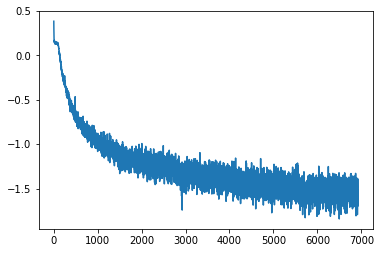

In [62]:
plt.plot(np.log(np.log(loss_val_hist)))

In [59]:
generate(as_matrix(["\x02" + "Hi, there." + "\x03"]), 75, tau=1e-5, n_samples=200, seed=42)

[[('How do you know?', 0.74552691),
  ("You don't know.", 0.87511861),
  ('Of course.', 1.0077978),
  ("What'd you want to know?", 1.0264655),
  ("I'm sorry.", 1.0527098),
  ('How can you look for me?', 1.1008555),
  ("How the hell would you go back so are you? What's that?", 1.1161273),
  ("That's nothing to help you?", 1.1577018),
  ('Let me know anything - all right. This is my ass.', 1.1899896),
  ('How was that?', 1.2024095),
  ("I'm going to cut you alone.", 1.217774),
  ('Good twenty minutes.', 1.2334508),
  ('Listen to me... have you?', 1.2622828),
  ("Come on, I'm going to see I was there with you again, That's the way I knew",
   1.2760723),
  ('What?', 1.2992123),
  ("That's a beautiful sacramy. You know I look like that.", 1.3018234),
  ("He says that he wants, but, you don't want to stay around here lived from t",
   1.3031696),
  ('Yes! I might know where I never had to be dead.', 1.3192397),
  ('Okay. What was it that?', 1.3378117),
  ("You planned on? How many people's 

In [63]:
def softmax(x_ij, axis=-1):
    x_ij = np.exp(x_ij - x_ij.max(axis=axis, keepdims=True))
    return x_ij / x_ij.sum(axis=axis, keepdims=True)

In [64]:
logits = op_predict_logits(be, bd)

rasta = np.random.RandomState(42)
gumbel = -np.log(-np.log(rasta.uniform(size=logits.shape)))


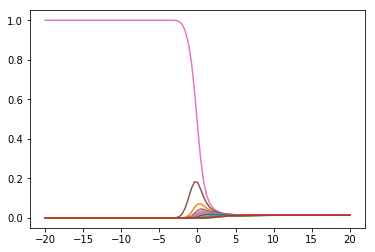

In [65]:
p = gumbel + logits
test = p[0, -10]
ttau = np.logspace(-20, 20, num=101, base=2)[:, np.newaxis]
test = softmax(test[np.newaxis] / ttau)

plt.plot(np.log2(ttau), test);

(array([  4.30355000e+05,   2.61762000e+06,   1.09582100e+06,
          2.05709000e+05,   3.29850000e+04,   5.28500000e+03,
          8.02000000e+02,   1.21000000e+02,   1.80000000e+01,
          2.00000000e+00]),
 array([ -2.69393827,  -0.84279984,   1.00833858,   2.859477  ,
          4.71061543,   6.56175385,   8.41289227,  10.2640307 ,
         12.11516912,  13.96630754,  15.81744597]),
 <a list of 10 Patch objects>)

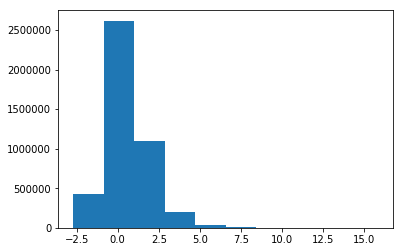

In [66]:
plt.hist(gumbel.flat)

In [67]:
for k, v, in zip(lasagne.layers.get_all_params(l_decoder_reembedder),
                 weights["l_decoder_reembedder"]):
    print (k, v.shape)

decoder/gru_00.W_in_to_updategate (32, 256)
decoder/gru_00.W_hid_to_updategate (256, 256)
decoder/gru_00.b_updategate (256,)
decoder/gru_00.W_in_to_resetgate (32, 256)
decoder/gru_00.W_hid_to_resetgate (256, 256)
decoder/gru_00.b_resetgate (256,)
decoder/gru_00.W_in_to_hidden_update (32, 256)
decoder/gru_00.W_hid_to_hidden_update (256, 256)
decoder/gru_00.b_hidden_update (256,)
decoder/gru_00.hid_init (1, 256)
encoder/gru_00.W_in_to_updategate (32, 256)
encoder/gru_00.W_hid_to_updategate (256, 256)
encoder/gru_00.b_updategate (256,)
encoder/gru_00.W_in_to_resetgate (32, 256)
encoder/gru_00.W_hid_to_resetgate (256, 256)
encoder/gru_00.b_resetgate (256,)
encoder/gru_00.W_in_to_hidden_update (32, 256)
encoder/gru_00.W_hid_to_hidden_update (256, 256)
encoder/gru_00.b_hidden_update (256,)
encoder/gru_00.hid_init (1, 256)
encoder/gru_01.W_in_to_updategate (256, 256)
encoder/gru_01.W_hid_to_updategate (256, 256)
encoder/gru_01.b_updategate (256,)
encoder/gru_01.W_in_to_resetgate (256, 256)
en

In [ ]:
# list(zip(trainable[1:], weights["l_decoder_reembedder"]))

In [55]:
for be, bd in generate_batch(32, max_len=512):
    break

In [79]:
op_train(bd, be)

array(2.7703378200531006)

In [81]:
ass = h_0.eval({v_gen_input: be})

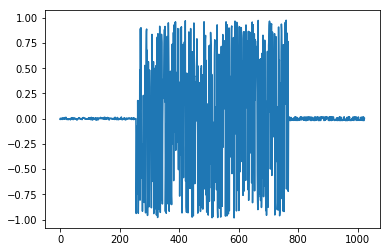

In [82]:
plt.plot(ass[0])

<hr/>

The older generator

In [43]:
# Generator's one step update function
def generator_step(x_tm1, h_tm1, m_tm1, tau, eps):
    """One step of the generative decoder version."""
    # x_tm1 is `batch` int8, h_tm1 is `batch x ...`
    # m_tm1 is `batch`, tau, eps are scalars

    # embed the previous character. x_t is `batch x embed`
    x_t = l_embed_char.get_output_for(x_tm1, deterministic=True)

    # collect the inputs
    inputs = {l_decoder_embed: x_t.dimshuffle(0, "x", 1),
              l_decoder_mask: m_tm1.dimshuffle(0, "x")}

    # Connect the prev variables to the the hidden and stack state feeds
    j = 0
    for layer in dec_rnn_layers:
        inputs[layer.hid_init] = slice_(h_tm1, j, layer.num_units)
        j += layer.num_units

    # Get the outputs
    outputs = [l_decoder_reembedder] + dec_rnn_layers_sliced

    # propagate through the decoder column
    logit_t, *h_t_list = lasagne.layers.get_output(outputs, inputs,
                                                   deterministic=True)

    logit_t = logit_t[:, 0]
    prob_t = tt.nnet.softmax(logit_t)

    # Gumbel-softmax sampling: Gumbel (e^{-e^{-x}}) distributed random noise
    gumbel = -tt.log(-tt.log(theano_random_state.uniform(size=logit_t.shape) + eps) + eps)
#     logit_t = theano.ifelse.ifelse(tt.gt(tau, 0), gumbel + logit_t, logit_t)
#     inv_temp = theano.ifelse.ifelse(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))
    logit_t = tt.switch(tt.gt(tau, 0), gumbel + logit_t, logit_t)
    inv_temp = tt.switch(tt.gt(tau, 0), 1.0 / tau, tt.constant(1.0))

    # Pick one element
    x_t = tt.cast(tt.argmax(tt.nnet.softmax(logit_t * inv_temp), axis=-1), x_tm1.dtype)

    # Pack the hidden states
    h_t = tt.concatenate(h_t_list, axis=-1)

    # Compute the mask and inhibit the propagation on a stop symbol.
    # Recurrent layers return the previous state if m_tm1 is Fasle
    m_t = m_tm1 & tt.gt(x_t, vocab.index("\x03"))
    x_t = tt.switch(m_t, x_t, vocab.index("\x03"))

    # There is no need to freeze the states as they will be frozen by
    # the RNN passthrough according to the mask `m_t`.

    # Get the estimated probability of the picked symbol.
    p_t = prob_t[tt.arange(x_t.shape[0]), x_t]
    return x_t, h_t, m_t, p_t

h_0 = tt.concatenate(dec_hid_inits, axis=-1)

x_0 = tt.fill(tt.zeros((v_gen_input.shape[0],), dtype="int32"),
              vocab.index("\x02"))

m_0 = tt.ones((v_gen_input.shape[0],), 'bool')

result, updates = theano.scan(generator_step, sequences=None, n_steps=n_steps,
                              outputs_info=[x_0, h_0, m_0, None],
                              strict=False, return_list=True,
                              non_sequences=[tau, eps], go_backwards=False,
                              name="generator/scan")
x_t, h_t, m_t, p_t = [r.swapaxes(0, 1) for r in result]

compile_mode = theano.Mode(optimizer="fast_run", linker="cvm")
op_generate = theano.function([v_gen_input, n_steps, tau],
                              [x_t, h_t, m_t, p_t],
                              updates=updates, givens={eps: floatX(1e-20)},
                              mode=compile_mode)

def generate(questions, n_steps, n_samples=10, tau=0, seed=None):
    results = []
    for question in questions:
        # Replicate the query
        question = np.repeat(question[np.newaxis], n_samples, axis=0)
        if seed is not None:
            theano_random_state.seed(seed)
        x_t, h_t, m_t, p_t = op_generate(question, n_steps, tau)

        # may produce NaN, but they are shifted in the back by arsort
        perplexity, n_chars = (- np.log2(p_t) * m_t).sum(axis=-1), m_t.sum(axis=-1)
        perplexity /= n_chars

        result = []
        for i in perplexity.argsort():
            reply = "".join(map(vocab.__getitem__, x_t[i, :n_chars[i]]))
            result.append((reply, perplexity[i]))
        results.append(result)
    return results